In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,auc,classification_report,precision_score,recall_score,accuracy_score,f1_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [30]:
df = pd.read_csv("cleaned_data.csv")


In [31]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2.0,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1.0,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2.0,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,0.0,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,0.0,0,27496.0,152.0,39,0


In [32]:
df['Region_Code'].describe()

count    381109.000000
mean         26.388807
std          13.229888
min           0.000000
25%          15.000000
50%          28.000000
75%          35.000000
max          52.000000
Name: Region_Code, dtype: float64

In [33]:
df['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [34]:
X=df.drop(columns=['Response','Policy_Sales_Channel','id'])
Y=df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [35]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', # determining the threshold in a better way 
    eval_metric='auc',
    # Handling the class Imbalance in a Better way
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handles class imbalance
    learning_rate=0.1,
    max_depth=10,
    n_estimators=200
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
print("The Number of Samples Having Negative Response are : ",len(df[df['Response']==0]))
print("The Number of Samples Having Positive Response are : ",len(df[df['Response']==1]))

print("The chances of predicting Negative Randomly is : ",len(df[df['Response']==0])/len(df[df['Response']==1]))

The Number of Samples Having Negative Response are :  334399
The Number of Samples Having Positive Response are :  46710
The chances of predicting Negative Randomly is :  7.15904517233997


In [37]:
y_pred=xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     66699
           1       0.30      0.86      0.44      9523

    accuracy                           0.73     76222
   macro avg       0.64      0.78      0.63     76222
weighted avg       0.89      0.73      0.77     76222



#### Evaluating the Model Performance on the Basis of the Metrics 
1. We have to increase the **Precision** as we don't want to waste resources on advertising were there is only 29% that customer ends up buying the Car insurance 
2. **Recall (True Positive Rate)** should be balanced at the same time as I want my model to predict More True Positives out of the actual true positivies available . We don't want to miss out on actual customers willing to take the Vehicle Insurance
3. **False Positive Rate (fpr)** --> Out of all the *actual_negatives* how many *false_positives* does our model detects

In [38]:
y_pred

array([0, 1, 1, ..., 0, 0, 0])

In [39]:
plt.style.use("fivethirtyeight")

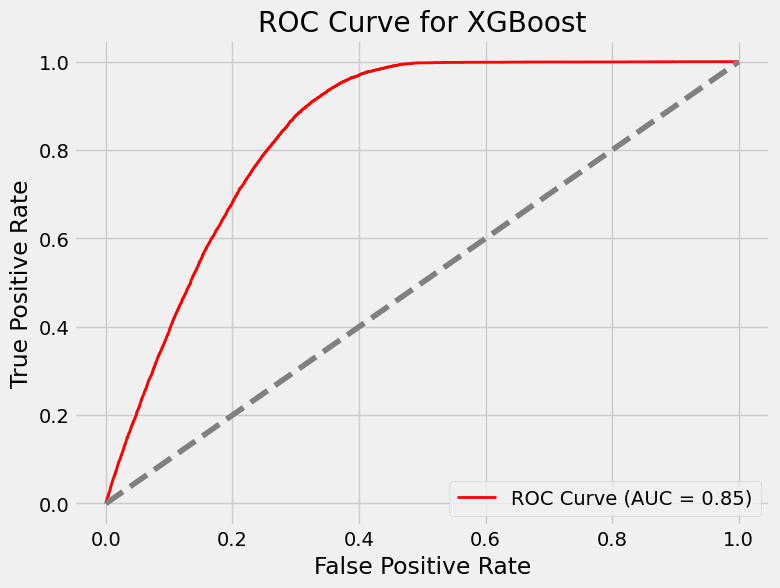

ROC-AUC Score: 0.8453


In [40]:
y_probs = xgb_model.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

# Print AUC Score
print(f"ROC-AUC Score: {roc_auc:.4f}")

#### Receiver Operator Characteristic Curve 
1. *Threshold Values* --> Values at which we keep the clasification if the threshold value is 0.4 for our model then all the predicted probabs >= 0.4 will be classified as Positive and <0.4 as Negatives 
2. *True Positive rate & False Positive Rate Tradeoff* --> Depending upon the Business Problems we have to come up with a optimal threshold value for the problem we are trying to solve 

#### Model Evaluation For the Default Threshold of 50 %

In [41]:
print("The precision Score for 0.5 threshold value is : ",precision_score(y_test,y_pred))
print("The Recall Score for 0.5 threshold value is : ",recall_score(y_test,y_pred))
print("The Accuracy Score for 0.5 threshold value is : ",accuracy_score(y_test,y_pred))

The precision Score for 0.5 threshold value is :  0.29835586408476433
The Recall Score for 0.5 threshold value is :  0.8575028877454584
The Accuracy Score for 0.5 threshold value is :  0.7302484846894597


#### Model Evaluation for Different Threholds 

In [42]:
thresholds_try =[0.60,0.70,0.72,0.74,0.75,0.80]

for threshold in thresholds_try:
    y_pred_adjusted = (y_probs >= threshold).astype(int)
    print("*****************************************************************************************")
    print("The precision Score for ",threshold," threshold value is : ",100*precision_score(y_test,y_pred_adjusted))
    print("The Recall Score for ",threshold," threshold value is : ",100*recall_score(y_test,y_pred_adjusted))
    print("The F1 Score for ",threshold," threshold value is : ",100*f1_score(y_test,y_pred_adjusted))
    print("The Accuracy Score for ",threshold," threshold value is : ",100*accuracy_score(y_test,y_pred_adjusted))
    print("")
    print("*****************************************************************************************")


*****************************************************************************************
The precision Score for  0.6  threshold value is :  31.45875208484797
The Recall Score for  0.6  threshold value is :  77.24456578809199
The F1 Score for  0.6  threshold value is :  44.70917157965113
The Accuracy Score for  0.6  threshold value is :  76.13025110860382

*****************************************************************************************
*****************************************************************************************
The precision Score for  0.7  threshold value is :  33.835341365461844
The Recall Score for  0.7  threshold value is :  60.1596135671532
The F1 Score for  0.7  threshold value is :  43.31128331128331
The Accuracy Score for  0.7  threshold value is :  80.32457820576737

*****************************************************************************************
*****************************************************************************************
The precis

**Dumping the Model in Pickle Format** 

In [21]:
import pickle

with open("xgbModel.pkl","wb") as file :
    pickle.dump(xgb_model,file)

#### Using Min-Max Scaler to Check the Performance of the XGBoost 

In [18]:
scaler = MinMaxScaler()

df['Annual_Premium']=scaler.fit_transform(df[['Annual_Premium']])
df['Vintage']=scaler.fit_transform(df[['Vintage']])
df['Region_Code']=scaler.fit_transform(df[['Region_Code']])

In [19]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,0.538462,0,2.0,1,0.070366,26.0,0.716263,1
1,2,1,76,1,0.057692,0,1.0,0,0.057496,26.0,0.598616,0
2,3,1,47,1,0.538462,0,2.0,1,0.066347,26.0,0.058824,1
3,4,1,21,1,0.211538,1,0.0,0,0.048348,152.0,0.667820,0
4,5,0,29,1,0.788462,1,0.0,0,0.046259,152.0,0.100346,0


#### Splitting the Train-Test Again as they we previously split on the Non-Scaled Attributes of the Dataset

In [ ]:
# X=df.drop(columns=['Response','Policy_Sales_Channel','id'])
# Y=df['Response']
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
scaledModel=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200
)

scaledModel.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
y_pred=scaledModel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66699
           1       0.29      0.93      0.44      9523

    accuracy                           0.70     76222
   macro avg       0.64      0.80      0.62     76222
weighted avg       0.90      0.70      0.75     76222



**Hence it can concluded that there was no Significant Impact of Scaling on the Predictions and Training of the XGBoost Model**

### Using SMOTE  (Synthetic Minority Oversampling Technique)

In [45]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [23]:
print("Before SMOTE Imbalance Present in the training Example :", Counter(y_train))

Before SMOTE Imbalance Present in the training Example : Counter({0: 267700, 1: 37187})


In [24]:
# Upsampling the Minority Class Using SMOTE 
smote = SMOTE(sampling_strategy='auto', random_state=42)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [25]:
print("After SMOTE Imbalance Present in the training Example :", Counter(y_train_resampled))

After SMOTE Imbalance Present in the training Example : Counter({1: 267700, 0: 267700})


#### Fitting the Model based on the resampled Train Data

In [26]:
smote_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200
)


smote_xgb.fit(X_train_resampled,y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
y_pred=smote_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     66699
           1       0.32      0.56      0.41      9523

    accuracy                           0.80     76222
   macro avg       0.63      0.70      0.64     76222
weighted avg       0.85      0.80      0.82     76222



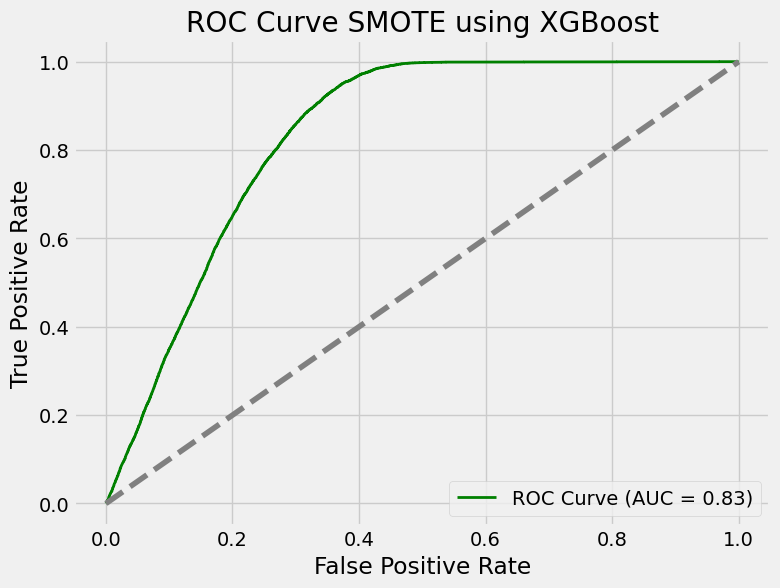

ROC-AUC Score: 0.8345


In [28]:
y_probs = smote_xgb.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SMOTE using XGBoost')
plt.legend(loc='lower right')
plt.show()

# Print AUC Score
print(f"ROC-AUC Score: {roc_auc:.4f}")

In [29]:
thresholds_try =[0.60,0.70,0.72,0.74,0.75,0.80]

for threshold in thresholds_try:
    y_pred_adjusted = (y_probs >= threshold).astype(int)
    print("*****************************************************************************************")
    print("The precision Score for ",threshold," threshold value is : ",100*precision_score(y_test,y_pred_adjusted))
    print("The Recall Score for ",threshold," threshold value is : ",100*recall_score(y_test,y_pred_adjusted))
    print("The F1 Score for ",threshold," threshold value is : ",100*f1_score(y_test,y_pred_adjusted))
    print("The Accuracy Score for ",threshold," threshold value is : ",100*accuracy_score(y_test,y_pred_adjusted))
    print("")
    print("*****************************************************************************************")

*****************************************************************************************
The precision Score for  0.6  threshold value is :  33.14922480620155
The Recall Score for  0.6  threshold value is :  35.923553502047675
The F1 Score for  0.6  threshold value is :  34.48067328528952
The Accuracy Score for  0.6  threshold value is :  82.94324473249193

*****************************************************************************************
*****************************************************************************************
The precision Score for  0.7  threshold value is :  32.39524702939337
The Recall Score for  0.7  threshold value is :  16.318387062900346
The F1 Score for  0.7  threshold value is :  21.70391061452514
The Accuracy Score for  0.7  threshold value is :  85.29033612342893

*****************************************************************************************
*****************************************************************************************
The prec

### Using Undersampling Techinique for the Dataset as the Oversampling does not have a Significant impact on the Model

1. Approach here the goal is to first oversample the Majority class and then undersample the resample data (Hybrid)
- Hybird approach is in general effective as it helps in retaining the important patterns in the Majority class which can be lost if we try to use only undersampling 
- Where as when we try to use Only Oversampling it may end up generating lot of noisy Data Making it very difficult for the model to capture actual patterns 

In [43]:
from imblearn.under_sampling import RandomUnderSampler


In [100]:
print("Before SMOTE oversampling Balance Minority : ",Counter(y_train))

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE oversampling Balance : ",Counter(y_resampled))


undersample = RandomUnderSampler(sampling_strategy=1.0, random_state=42) 
X_final, y_final = undersample.fit_resample(X_resampled, y_resampled)


print("After Hybrid Sampling (SMOTE + Undersampling):", Counter(y_final))

Before SMOTE oversampling Balance Minority :  Counter({0: 267700, 1: 37187})
After SMOTE oversampling Balance :  Counter({0: 267700, 1: 133850})
After Hybrid Sampling (SMOTE + Undersampling): Counter({0: 133850, 1: 133850})


In [105]:
hybird_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=len(y_final[y_final == 0]) / len(y_final[y_final == 1]), 
    learning_rate=0.1,
    max_depth=12,
    n_estimators=150,
    # early_stopping_rounds=20
)


hybird_xgb.fit(X_final,y_final,eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.83091
[1]	validation_0-auc:0.83296
[2]	validation_0-auc:0.83288
[3]	validation_0-auc:0.83323
[4]	validation_0-auc:0.83346
[5]	validation_0-auc:0.83440
[6]	validation_0-auc:0.83457
[7]	validation_0-auc:0.83509
[8]	validation_0-auc:0.83539
[9]	validation_0-auc:0.83583
[10]	validation_0-auc:0.83606
[11]	validation_0-auc:0.83621
[12]	validation_0-auc:0.83632
[13]	validation_0-auc:0.83631
[14]	validation_0-auc:0.83653
[15]	validation_0-auc:0.83676
[16]	validation_0-auc:0.83696
[17]	validation_0-auc:0.83714
[18]	validation_0-auc:0.83719
[19]	validation_0-auc:0.83735
[20]	validation_0-auc:0.83751
[21]	validation_0-auc:0.83752
[22]	validation_0-auc:0.83758
[23]	validation_0-auc:0.83753
[24]	validation_0-auc:0.83776
[25]	validation_0-auc:0.83788
[26]	validation_0-auc:0.83792
[27]	validation_0-auc:0.83781
[28]	validation_0-auc:0.83789
[29]	validation_0-auc:0.83798
[30]	validation_0-auc:0.83806
[31]	validation_0-auc:0.83810
[32]	validation_0-auc:0.83818
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [106]:
y_pred=hybird_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     66699
           1       0.32      0.69      0.43      9523

    accuracy                           0.78     76222
   macro avg       0.63      0.74      0.65     76222
weighted avg       0.87      0.78      0.81     76222



In [109]:
y_probs_hyrbid = hybird_xgb.predict_proba(X_test)[:, 1] 
thresholds_try =[0.40,0.60,0.70,0.72,0.74,0.75,0.80]

for threshold in thresholds_try:
    y_pred_adjusted = (y_probs_hyrbid >= threshold).astype(int)
    print("*****************************************************************************************")
    print("The precision Score for ",threshold," threshold value is : ",100*precision_score(y_test,y_pred_adjusted))
    print("The Recall Score for ",threshold," threshold value is : ",100*recall_score(y_test,y_pred_adjusted))
    print("The F1 Score for ",threshold," threshold value is : ",100*f1_score(y_test,y_pred_adjusted))
    print("The Accuracy Score for ",threshold," threshold value is : ",100*accuracy_score(y_test,y_pred_adjusted))
    print("")
    print("*****************************************************************************************")


*****************************************************************************************
The precision Score for  0.4  threshold value is :  30.048590864917397
The Recall Score for  0.4  threshold value is :  81.17189961146698
The F1 Score for  0.4  threshold value is :  43.86064457557875
The Accuracy Score for  0.4  threshold value is :  74.03899136732177

*****************************************************************************************
*****************************************************************************************
The precision Score for  0.6  threshold value is :  33.13504273504274
The Recall Score for  0.6  threshold value is :  50.88732542266092
The F1 Score for  0.6  threshold value is :  40.13582905416598
The Accuracy Score for  0.6  threshold value is :  81.03434703891264

*****************************************************************************************
*****************************************************************************************
The preci